In [1]:
import psycopg2

from itertools import chain
import numpy as np
import pandas as pd
import bs4
from bs4 import BeautifulSoup
import requests 
from datetime import datetime, timedelta
import re
import pytz
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math as math

In [3]:
cur=conn.cursor()

In [4]:
#removed some AND clauses from cur.execute, issleeve isdeck
# COALESCE(cardquantity,maybecardquantity,1)
cur.execute('''SELECT cardname,carddate,AVG(pshipq) as AVGE,percentile_cont(0.5) WITHIN GROUP (ORDER BY pshipq) as MED,COUNT(*) as VLM 
    FROM (SELECT DISTINCT title,cardname,carddate,(price+shipping)/COALESCE(cardquantity,maybecardquantity,1) as pshipq FROM public.transactions
	WHERE possiblybad IS FALSE 
    AND (isboosterbox IS NULL OR isboosterbox IS FALSE)
	AND cardname IN(SELECT DISTINCT(cardname) FROM public.tourninfo)
	AND isfoil IS FALSE
    AND cardlanguage IN('english',NULL)
    AND cardset NOT IN('LEA','LEB','U')
    AND (isemblem IS NULL OR isemblem IS FALSE)
	AND cardspecial IS NULL
	AND isplaymat IS NULL
    AND isgraded IS NULL
    AND iscommanderdeck IS NULL
    AND isultra IS NULL
    AND (lotis IS FALSE OR lotis IS NULL)
    AND issleeve IS NULL
    AND isdeck IS NULL
    AND (iscommanderdeck IS NULL OR iscommanderdeck IS FALSE)
    AND (istoken IS NULL OR istoken IS FALSE)
	AND (othercards IS NULL OR othercards='Hour of Devastation;' OR transplit IS TRUE)
	AND saletype IN('normal','italic')) as foo GROUP BY carddate,cardname ORDER BY cardname,carddate ASC''')
# ,'italic'

In [5]:
rows=cur.fetchall()
cur.close()
conn.close()

utc_now = pytz.utc.localize(datetime.utcnow())
pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
pst_now=pst_now-timedelta(1)

In [6]:
df=pd.DataFrame(rows,columns=["cardname","carddate","avg","med","quant"]) 
df['carddate']=df['carddate']

In [7]:
overalllist=[]
for cardname in df["cardname"].unique():
    coeflist=[]
    regvals=df.loc[df['cardname'] == cardname].reset_index()
    if regvals['carddate'][len(regvals['carddate'])-1]!=str(pst_now.strftime('%Y-%m-%d')):
        new_row={'carddate':pst_now.strftime('%Y-%m-%d'),'cardname':cardname,'avg':None,'med':None,'quant':None}
        regvals = regvals.append(new_row, ignore_index=True).fillna(method='ffill')
    regvals['carddate']=regvals['carddate'].astype('datetime64[ns]')  
    regvals=regvals.set_index('carddate')
#     regvals=regvals[['avg','med','quant']]
    regvals=regvals.asfreq('D', method='ffill')
    regvals=regvals.reset_index()
    regvals["carddate"]=regvals["carddate"]-regvals.iloc[0]["carddate"]
    regvals["carddate"]=regvals["carddate"].astype('int64')/86400000000000
    for frac in [1-1/2**i for i in range(0,math.floor(math.log(len(regvals),2)))]:
#     for frac in [0,.5]:
        if len(regvals.iloc[math.floor(frac*len(regvals)):len(regvals)])<4:
            pass
        else:
#             data[['flow_h','flow_c']].min(axis=1)
            minarr=np.minimum(regvals.iloc[math.floor(frac*len(regvals)):len(regvals)]["avg"],regvals.iloc[math.floor(frac*len(regvals)):len(regvals)]["med"])
            regmin=LinearRegression().fit(np.array(regvals.iloc[math.floor(frac*len(regvals)):len(regvals)]["carddate"]).reshape(-1, 1),minarr)
            regmed=LinearRegression().fit(np.array(regvals.iloc[math.floor(frac*len(regvals)):len(regvals)]["carddate"]).reshape(-1, 1),regvals.iloc[math.floor(frac*len(regvals)):len(regvals)]["med"])
            regavg=LinearRegression().fit(np.array(regvals.iloc[math.floor(frac*len(regvals)):len(regvals)]["carddate"]).reshape(-1, 1),regvals.iloc[math.floor(frac*len(regvals)):len(regvals)]["avg"])
            medcoef=regmed.coef_[0]
            avgcoef=regavg.coef_[0]
            mincoef=regmin.coef_[0]
            coeflist.append((mincoef,len(regvals.iloc[math.floor(frac*len(regvals)):len(regvals)])))
            coeflist.append((medcoef,len(regvals.iloc[math.floor(frac*len(regvals)):len(regvals)])))
            coeflist.append((avgcoef,len(regvals.iloc[math.floor(frac*len(regvals)):len(regvals)])))
    coeflist.append(cardname)
    overalllist.append(coeflist[::-1])
    
# coefdf=pd.DataFrame(overalllist,columns=["cardname","mecoef1","avgcoef1","medcoef.5","avgcoef.5"])
coefdf=pd.DataFrame(overalllist)

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [9]:
coefdf.dropna(thresh=2).sort_values(by=1,axis=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
411,Indomitable Creativity,"(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(1.23689742937131e-32, 12)","(1.23689742937131e-32, 12)","(1.23689742937131e-32, 12)","(0.0, 24)","(0.0, 24)","(0.0, 24)","(-1.0603582168607291e-33, 47)","(-1.0603582168607291e-33, 47)","(-1.0603582168607291e-33, 47)","(0.0, 93)","(0.0, 93)","(0.0, 93)","(0.007372655087373016, 185)","(0.007372655087373016, 185)","(0.007372655087373016, 185)",None,None,None
312,Gaea's Revenge,"(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(4.700933507791549e-33, 11)","(4.700933507791549e-33, 11)","(4.700933507791549e-33, 11)","(-3.313722707724744e-33, 22)","(-3.313722707724744e-33, 22)","(-3.313722707724744e-33, 22)","(0.0, 44)","(0.0, 44)","(0.0, 44)","(-4.138139280229502e-34, 88)","(-4.138139280229502e-34, 88)","(-4.138139280229502e-34, 88)","(0.007253353836100786, 175)","(0.007253353836100786, 175)","(0.007253353836100786, 175)",None,None,None
593,"Oviya Pashiri, Sage Lifecrafter","(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(1.23689742937131e-32, 12)","(1.23689742937131e-32, 12)","(1.23689742937131e-32, 12)","(-3.0997037617697085e-33, 23)","(-3.0997037617697085e-33, 23)","(-3.0997037617697085e-33, 23)","(0.0, 45)","(0.0, 45)","(0.0, 45)","(0.004913858141374923, 90)","(0.004913858141374923, 90)","(0.004913858141374923, 90)","(0.007572385791535691, 179)","(0.007572385791535691, 179)","(0.007572385791535691, 179)",None,None,None
181,Dark Salvation,"(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(4.700933507791549e-33, 11)","(4.700933507791549e-33, 11)","(4.700933507791549e-33, 11)","(0.0, 21)","(0.0, 21)","(0.0, 21)","(0.0, 41)","(0.0, 41)","(0.0, 41)","(-1.3801740022735092e-33, 82)","(-1.3801740022735092e-33, 82)","(-1.3801740022735092e-33, 82)","(0.0005045367492410737, 164)","(0.0005045367492410737, 164)","(0.0005045367492410737, 164)",None,None,None
338,Goblin Trashmaster,"(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(1.23689742937131e-32, 12)","(1.23689742937131e-32, 12)","(1.23689742937131e-32, 12)","(-3.0997037617697085e-33, 23)","(-3.0997037617697085e-33, 23)","(-3.0997037617697085e-33, 23)","(3.285399771932637e-33, 46)","(3.285399771932637e-33, 46)","(3.285399771932637e-33, 46)","(0.004113712654806382, 91)","(0.004113712654806382, 91)","(0.004113712654806382, 91)","(0.005527360590617047, 182)","(0.005527360590617047, 182)","(0.005527360590617047, 182)",None,None,None
171,Crush of Tentacles,"(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(1.23689742937131e-32, 12)","(1.23689742937131e-32, 12)","(1.23689742937131e-32, 12)","(0.0, 24)","(0.0, 24)","(0.0, 24)","(5.136928090762691e-34, 48)","(5.136928090762691e-34, 48)","(5.136928090762691e-34, 48)","(3.6317653712707714e-34, 96)","(3.6317653712707714e-34, 96)","(3.6317653712707714e-34, 96)","(0.001974872949326058, 191)","(0.001974872949326058, 191)","(0.001974872949326058, 191)",None,None,None
699,Scuttling Doom Engine,"(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(1.23689742937131e-32, 12)","(1.23689742937131e-32, 12)","(1.23689742937131e-32, 12)","(0.0, 24)","(0.0, 24)","(0.0, 24)","(5.136928090762691e-34, 48)","(5.136928090762691e-34, 48)","(5.136928090762691e-34, 48)","(0.006789334346973092, 95)","(0.006789334346973092, 95)","(0.006789334346973092, 95)","(0.008933246638111684, 189)","(0.008933246638111684, 189)","(0.008933246638111684, 189)",None,None,None
522,Mirrorpool,"(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(-2.357172806763952e-32, 6)","(-1.23689742937131e-32, 12)","(-1.23689742937131e-32, 12)","(-1.23689742937131e-32, 12)","(0.0, 24)","(0.0, 24)","(0.0, 24)","(5.136928090762691e-34, 48)","(5.136928090762691e-34, 48)","(5.13692809

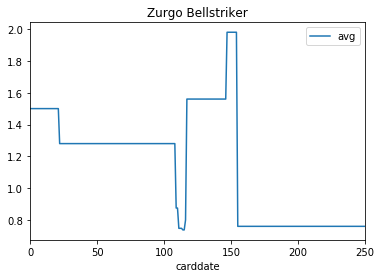

In [10]:
regvals.plot('carddate','avg',title=cardname)

In [11]:
regvals

,carddate,index,cardname,avg,med,quant
0,0.0,17650.0,Zurgo Bellstriker,1.5000,1.5000,1
1,1.0,17650.0,Zurgo Bellstriker,1.5000,1.5000,1
2,2.0,17650.0,Zurgo Bellstriker,1.5000,1.5000,1
3,3.0,17650.0,Zurgo Bellstriker,1.5000,1.5000,1
4,4.0,17650.0,Zurgo Bellstriker,1.5000,1.5000,1
5,5.0,17650.0,Zurgo Bellstriker,1.5000,1.5000,1
6,6.0,17650.0,Zurgo Bellstriker,1.5000,1.5000,1
7,7.0,17650.0,Zurgo Bellstriker,1.5000,1.5000,1
8,8.0,17650.0,Zurgo Bellstriker,1.5000,1.5000,1
9,9.0,17650.0,Zurgo Bellstriker,1.5000,1.5000,1
